In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd
from ipynb.fs.defs.utility import *
from dataclasses import dataclass

In [76]:
# min frequency of each oscillator
VCO_F_MIN, VCO_F_MAX = 20, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000

WAVE_SIN, WAVE_TRI, WAVE_SQR, WAVE_SAW  = 0, 1, 2, 3 # wavetable shape indices

def additive_wave(waveshape, f, dur, Fs=48000, harmonic_derating=1):

    t = np.linspace(0, dur, int(dur*Fs), endpoint=False)
    x = 2*np.pi*t*f
    
    # add the fundamental
    wave = np.sin(x)

    if waveshape == WAVE_SIN:
        return wave

    max_harmonics = int(np.floor(Fs/2/f/harmonic_derating))

    # zero out the phase increments
    tri_offs = saw_offs = square_offs = 0

    # process harmonics higher than the first
    for k in range(2, max_harmonics+1):
        if waveshape == WAVE_TRI and k % 2 != 0: # only odd harmonics
            # tri
            tri_offs += np.pi
            new_wave_tri = (1/(k*k)) * np.sin(x*k + tri_offs)
            wave = [a + b for a, b in zip(wave, new_wave_tri)]
        elif waveshape == WAVE_SQR and k % 2 != 0: # only odd harmonics
            # square
            new_wave_square = (1/k) * np.sin(x*k)
            wave = [a + b for a, b in zip(wave, new_wave_square)]
        elif waveshape == WAVE_SAW:
            # saw
            saw_offs += np.pi
            new_wave_saw = (1/k) * np.sin(x*k + saw_offs)
            wave = [a + b for a, b in zip(wave, new_wave_saw)]

    return normalize(wave)

def plot_my_spectrogram(wave, dur, NFFT=128, Fs=48000, fmin=0, fmax=24000, dbmin=-80, dbmax=0):
    fig = plt.figure()
    ax = fig.add_subplot()
    _, _, _, im = ax.specgram(wave, Fs=Fs, NFFT=NFFT, noverlap=120, cmap='inferno');
    plt.axis([0, dur, fmin, fmax])
    ax.set_ylabel('frequency (Hz)')
    ax.set_xlabel('time (s)')
    cbar = plt.colorbar(im, ax=ax)
    plt.sci(im)
    plt.clim(dbmin, dbmax)
    cbar.set_label('Amplitude (dB)')
    cbar.minorticks_on()
    plt.show()

def plot_my_magnitude_spectrum(wave, Fs=48000, fmin=0, fmax=24000, dbmin=-80, dbmax=0):
    plt.figure(figsize=(20,5))
    plt.axis([fmin, fmax, dbmin, dbmax])
    plt.magnitude_spectrum(wave, scale='dB', Fs=Fs);
    
    
def plot_error(cycle1, cycle2, domain='frequency'):
    plt.figure()
    if domain == 'time':
        plt.plot([n1-n2 for n1, n2 in zip(cycle1, cycle2)])
    else:
        f1, _, _ = plt.magnitude_spectrum(cycle1)
        f2, _, _ = plt.magnitude_spectrum(cycle2)
        plt.figure()
        plt.plot([n1-n2 for n1, n2 in zip(f1, f2)])

# PolyBLEP

In [206]:
# based on:
# http://research.spa.aalto.fi/publications/papers/smc2010-phaseshaping/phaseshapers.py
def poly_blep(phase_dec, phase_inc):
    correction = 0
    if phase_dec > (1-phase_inc): # before transition
        t = (phase_dec - 1) / phase_inc # converts phase to t = [-1, 0]
        correction = t*t + t+t + 1 # 2*(t^2/2 + t + 0.5)
    elif phase_dec < phase_inc: # after transition
        t = phase_dec / phase_inc # converts phase to t = [0, 1]
        correction = t+t - t*t - 1 # 2*(t-t^2/2-0.5)
    else:
        correction = 0
    return correction

def polyblep_this(t):
    return 0.5 * t * t

def polyblep_next(t):
    t = 1 - t
    return -0.5 * t * t

# CV

In [207]:
CV_CH_WAVESHAPE = 0
CV_CH_MODE = 1
CV_CH_COARSE_ADJ = 2
CV_CH_FINE_ADJ = 3
CV_CH_VPO = 4
CV_CH_FM_EXP = 5
CV_CH_PWM = 6

# specifies human-readable name for CV channel
channel_idx_alias = {
    'waveshape': CV_CH_WAVESHAPE,
    'mode': CV_CH_MODE,
    'coarse_adj': CV_CH_COARSE_ADJ,
    'fine_adj': CV_CH_FINE_ADJ,
    'vpo': CV_CH_VPO,
    'fm_exp': CV_CH_FM_EXP,
    'pwm': CV_CH_PWM,
}

# specifies the raw value ranges for each CV channel
ranges = {
    CV_CH_WAVESHAPE: (0,1),
    CV_CH_MODE: (0,1),
    CV_CH_COARSE_ADJ: (0,1),
    CV_CH_FINE_ADJ: (0,1),
    CV_CH_VPO: (-5,5),
    CV_CH_FM_EXP: (-5,5),
    CV_CH_PWM: (-5,5),
}

class CV:
    ### a CV input belonging to a specified channel ###
    ### the input and input range are specified ###
    ### the input is normalized to the range [0,1] ###
    
    def __init__(self, channel, raw_val):
        self.channel = channel
        self.range_min, self.range_max = ranges[channel]
        self.raw_val = raw_val
        self.normalized_val = translate_range(raw_val, self.range_min, self.range_max, 0, 1)
        
    def get_raw(self):
        return self.raw_val
    
    def get_normalized(self):
        return self.normalized_val

class CV_stream:
    ### a stream of CV values ###
    
    def __init__(self, channel, stream_list):
        self.stream = [CV(channel, val) for val in stream_list]

    def get(self, i):
        if i < 0 or i >= len(self.stream):
            return 0
        return self.stream[i]

class CV_stream_collection:
    ### a collection of CV streams ###
    
    def __init__(self):
        self.cv_collection = []
        
    def add_stream(self, stream):
        self.cv_collection.append(stream)
        
    def get_snapshot_at(self, i):
        return CV_snapshot([stream.get(i) for stream in self.cv_collection])

@dataclass
class CV_snapshot:
    ### represents a snapshot in time of CV values across all channels in a collection ###
    
    cv_values: [CV]
        
    def get_channel(self, channel):
        if channel < 0 or channel >= len(self.cv_values):
            return 0
        return self.cv_values[channel]

class CV_sim:
    ### a module that generates simulated CV inputs for a specified duration ###
    
    def __init__(self, dur=3, test_dict=None, Fs=48000):
        self.dur = dur
        self.test_dict = test_dict
        self.Fs = Fs
        self.N = int(dur * Fs)
        
        if test_dict:
            self.test_dict = test_dict
        else:
            self.test_dict = {
                'waveshape': self.const_inp(WAVE_SAW),
                'mode': self.const_inp(0),
                'coarse_adj': self.const_inp(0.445), # 437 Hz
                'fine_adj': self.const_inp(0),
                'vpo': self.const_inp(0),
                'fm_exp': self.const_inp(0),
                'pwm': self.const_inp(0),
            }
        
    def set(self, ch, inp):
        self.test_dict[ch] = inp
        
    def const_inp(self, val):            
        return [val] * self.N
        
    def ramp_inp(self, from_val, to_val):
        return np.linspace(from_val, to_val, self.N)

    def sin_inp(self, A, f):
        t = np.linspace(0, self.dur, self.N)
        return A*np.sin(2*np.pi*t*f)

# playback

In [260]:
### Sample calculation code inspired by Mutable Instruments Plaits

'''
// Copyright 2016 Emilie Gillet.
//
// Author: Emilie Gillet (emilie.o.gillet@gmail.com)
//
// Permission is hereby granted, free of charge, to any person obtaining a copy
// of this software and associated documentation files (the "Software"), to deal
// in the Software without restriction, including without limitation the rights
// to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
// copies of the Software, and to permit persons to whom the Software is
// furnished to do so, subject to the following conditions:
// 
// The above copyright notice and this permission notice shall be included in
// all copies or substantial portions of the Software.
// 
// THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
// IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
// FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
// AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
// LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
// OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
// THE SOFTWARE.
// 
// See http://creativecommons.org/licenses/MIT/ for more information.
//
// -----------------------------------------------------------------------------
'''

class Playback:
    
    def __init__(self, Fs=48000):
        self.Fs = Fs

    def get_Fs(self):
        return self.Fs

    def play(self, cvsim, polyblep=True, show_progress=False, listen=True, plot=True, buff_size=64):
        # parse the cvsim input
        cv_col = CV_stream_collection()
        for k in cvsim.test_dict.keys():
            ch = channel_idx_alias[k]
            cv_col.add_stream(CV_stream(ch, cvsim.test_dict[k]))

        # create N samples
        output = []
        i = 0
        phase = 0
        cycles = []
        cycle = []
        
        this_sample = next_sample = 0
        high = False
        
        while i < cvsim.N:
            
            # extract the cv for each channel
            cv_ss = cv_col.get_snapshot_at(i)
            waveshape = cv_ss.get_channel(CV_CH_WAVESHAPE)
            mode = cv_ss.get_channel(CV_CH_MODE)
            coarse_adj = cv_ss.get_channel(CV_CH_COARSE_ADJ)
            fine_adj = cv_ss.get_channel(CV_CH_FINE_ADJ)
            vpo = cv_ss.get_channel(CV_CH_VPO)
            fm_exp = cv_ss.get_channel(CV_CH_FM_EXP)
            pwm = cv_ss.get_channel(CV_CH_PWM)
    
            # determine the frequency based on the CV
            if mode.get_raw() == 0:
                coarse_translated = translate_range(coarse_adj.get_raw(), coarse_adj.range_min, coarse_adj.range_max, 0, 10)
                fine_translated = translate_range(fine_adj.get_raw(), fine_adj.range_min, fine_adj.range_max, 0, 1)
                f = VCO_F_MIN * 2**(coarse_translated + fine_translated)
                volt_from_vpo = vpo.get_raw()
                f *= 2**volt_from_vpo
                volt_from_fm = fm_exp.get_raw()
                f *= 2**volt_from_fm

                # clamp the frequency to within allowable range
                f = clamp(f, VCO_F_MIN, VCO_F_MAX)
            elif mode.get_raw() == 1:
                f = translate_range(coarse_adj.get_raw(), coarse_adj.range_min, coarse_adj.range_max, LFO_F_MIN, LFO_F_MAX)
            
            # PWM
            pw = translate_range(pwm.get_raw(), pwm.range_min, pwm.range_max, 0.1, 0.9)
            
            phase_inc = f / self.Fs
            
            # compute buff_size samples for the given CV            
            for _ in range(min(buff_size, cvsim.N-i)):  
                # save the cycle output
                if phase > (1 - phase_inc):
                    cycles.append(cycle)
                    cycle = []
                    
                this_sample = next_sample
                next_sample = 0
                
                phase += phase_inc
                                           
                if waveshape.get_raw() == WAVE_SIN:
                    y = np.sin(2*np.pi*phase)
                elif waveshape.get_raw() == WAVE_SAW: 
                    if phase >= 1:
                        phase -= 1
                        t = phase / phase_inc
                        this_sample -= polyblep_this(t)
                        next_sample -= polyblep_next(t)
                    if not polyblep:
                        this_sample = phase
                    y = (2 * this_sample) - 1
                    next_sample += phase
                elif waveshape.get_raw() == WAVE_SQR:
                    if (high and phase < pw) or (not high and phase >= pw):
                        t = (phase - pw) / phase_inc
                        this_sample += polyblep_this(t)
                        next_sample += polyblep_next(t)
                        high = phase >= pw
                    if phase >= 1:
                        phase -= 1
                        t = phase / phase_inc
                        this_sample -= polyblep_this(t)
                        next_sample -= polyblep_next(t)
                        high = False
                    next_sample += 0 if phase < pw else 1
                    this_sample = (2 * this_sample) - 1
                    if not polyblep:
                        this_sample = -1 if phase < pw else 1
                    y = this_sample
                    
                output.append(y)
                cycle.append(y)

                i += 1
                
                # progress indication
                if show_progress:
                    prog = 100*i/cvsim.N
                    if prog % 10 == 0:
                        print(prog, "%")                    

        wave = np.array(output)
        
        # create output audio and plot
        if listen:
            display(ipd.Audio(wave, rate=self.Fs))
        if plot:
            plot_my_spectrogram(wave, cvsim.dur, Fs=self.Fs)

        return wave, cycles

# examples

In [261]:
# create the playback task
pb = Playback()

def f_to_dec(f):
    return .1*np.log2(f/20)

## constant frequency

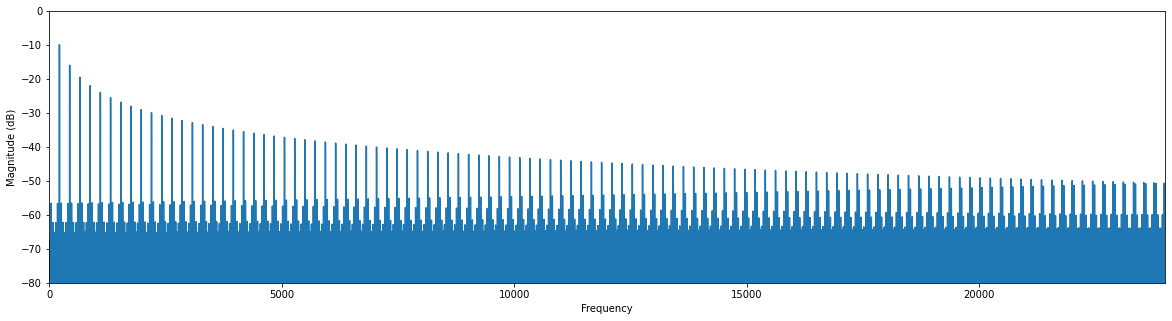

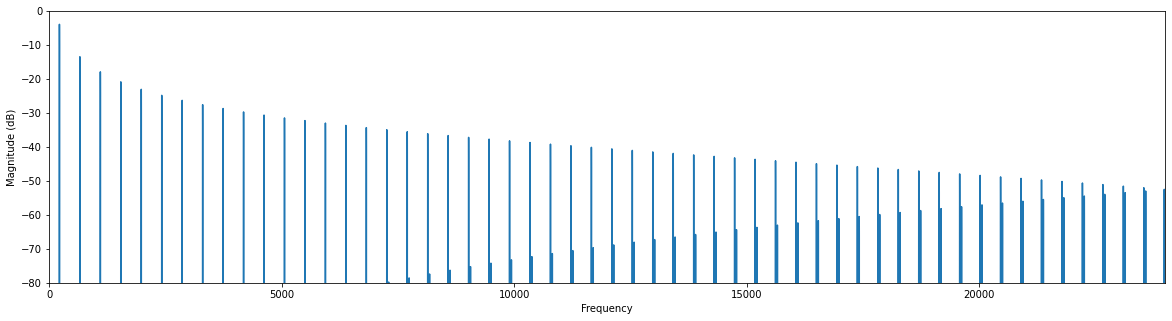

In [251]:
cvsim = CV_sim(dur=1)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SQR))
cvsim.set('coarse_adj', cvsim.const_inp(f_to_dec(220)))

# naive
wave2, cycles2 = pb.play(cvsim, plot=False, listen=True, polyblep=False); # no polyblep
plot_my_magnitude_spectrum(wave2)

# with polyblep
wave1, cycles1 = pb.play(cvsim, plot=False, listen=True, polyblep=True); # polyblep
plot_my_magnitude_spectrum(wave1)
# plt.plot(cycles1[0])

# additive wave
# wave = additive_wave(WAVE_SQR, 220, 1)
# plot_my_magnitude_spectrum(wave)
# display(ipd.Audio(wave, rate=48000))

## frequency sweep

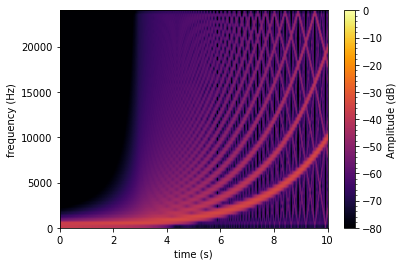

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7702: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


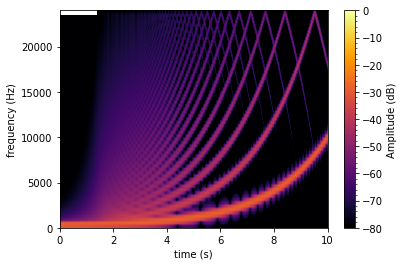

In [234]:
cvsim = CV_sim(dur=10)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SQR))
cvsim.set('coarse_adj', cvsim.ramp_inp(f_to_dec(100), f_to_dec(10000)))
wave_no_aa = pb.play(cvsim, polyblep=False)
wave = pb.play(cvsim);
# plot_my_magnitude_spectrum(wave[0:1000])
# plot_my_magnitude_spectrum(wave[230000:230500])

## fine adjust

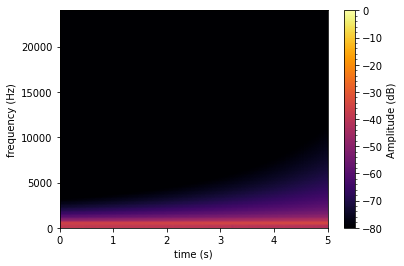

In [235]:
cvsim = CV_sim(dur=5)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SAW))
cvsim.set('coarse_adj', cvsim.const_inp(0.3))
cvsim.set('fine_adj', cvsim.ramp_inp(0, 1))
pb.play(cvsim);

## ramp one volt/octave at constant coarse

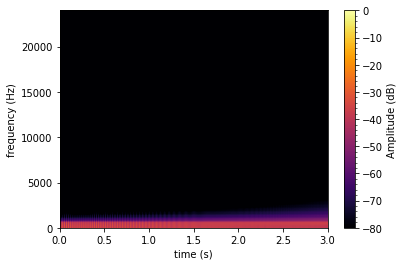

In [236]:
cvsim = CV_sim()
cvsim.set('coarse_adj', cvsim.const_inp(0.1))
cvsim.set('vpo', cvsim.ramp_inp(0, 2))
pb.play(cvsim);

## sinusoidal one volt/octave at wavetable boundary

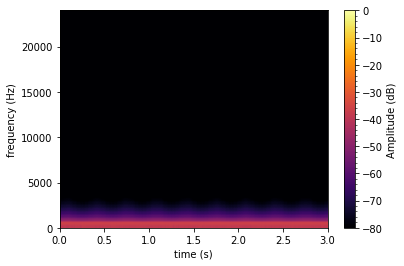

In [237]:
cvsim = CV_sim()
cvsim.set('coarse_adj', cvsim.const_inp(0.3))
cvsim.set('vpo', cvsim.sin_inp(A=0.1, f=3))
pb.play(cvsim);

## expo FM at constant coarse

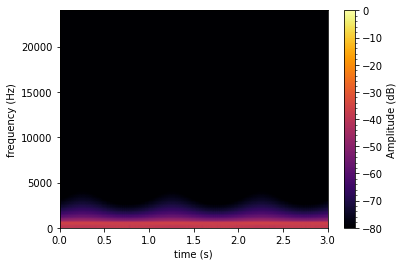

In [238]:
cvsim = CV_sim()
cvsim.set('coarse_adj', cvsim.const_inp(0.3))
cvsim.set('fm_exp', cvsim.sin_inp(A=0.3, f=1))
pb.play(cvsim);

## expo FM on ramping pitch

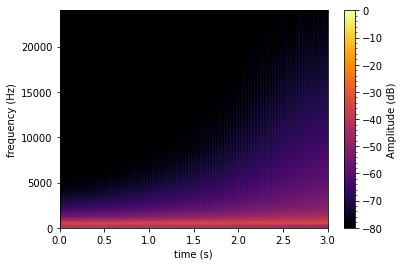

In [239]:
cvsim = CV_sim()
cvsim.set('coarse_adj', cvsim.ramp_inp(f_to_dec(220), f_to_dec(440)))
cvsim.set('fm_exp', cvsim.sin_inp(A=.1, f=30))
pb.play(cvsim);

## wave shape morphing

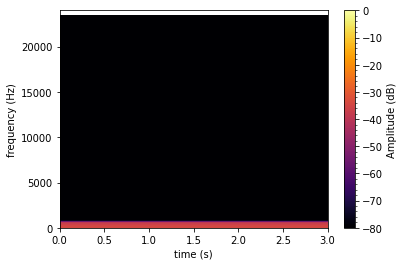

In [240]:
cvsim = CV_sim()
cvsim.set('waveshape', cvsim.ramp_inp(0, 4))
cvsim.set('coarse_adj', cvsim.const_inp(0.4))
pb.play(cvsim);

## LFO

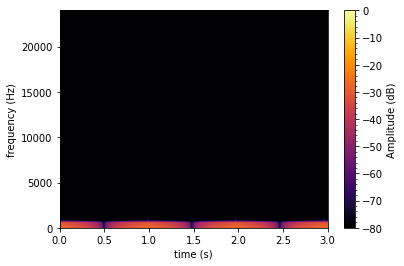

In [241]:
cvsim = CV_sim()
cvsim.set('waveshape', cvsim.const_inp(WAVE_SAW))
cvsim.set('mode', cvsim.const_inp(1))
cvsim.set('coarse_adj', cvsim.const_inp(0.001)) # 0.001 = 1 Hz
out = pb.play(cvsim);

## PWM

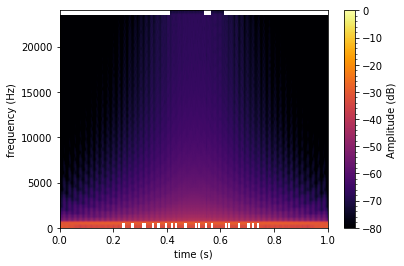

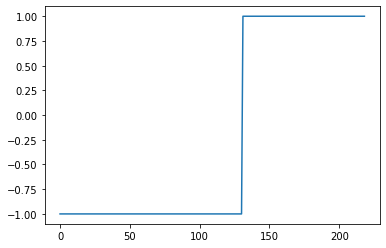

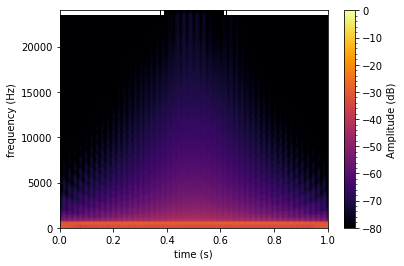

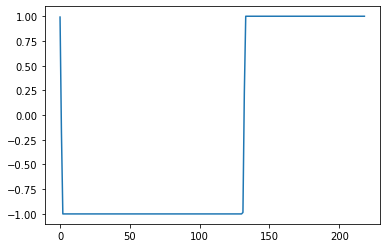

In [264]:
cvsim = CV_sim(dur=1)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SQR))
cvsim.set('coarse_adj', cvsim.const_inp(f_to_dec(220)))
# cvsim.set('pwm', cvsim.sin_inp(A=5, f=0.1))
cvsim.set('pwm', cvsim.ramp_inp(-5,5))


i = (len(cycles2) - 1) // 8
# naive
wave2, cycles2 = pb.play(cvsim, plot=True, listen=True, polyblep=False); # no polyblep
plt.plot(cycles2[i])

# with polyblep
wave1, cycles1 = pb.play(cvsim, plot=True, listen=True, polyblep=True); # polyblep
plt.figure()
plt.plot(cycles1[i])